<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product ">
</a> 


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="200" alt="cognitiveclass.ai logo">


<h1><h1>Pre-trained-Models with PyTorch </h1>


In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 
<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:


In [5]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2023-03-12 22:19:54--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  11.4MB/s    in 1m 42s  

2023-03-12 22:21:37 (24.2 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [6]:
!unzip -q Positive_tensors.zip 

In [7]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2023-03-12 22:23:15--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  33.2MB/s    in 58s     

2023-03-12 22:24:13 (34.8 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



We will install torchvision:


In [8]:
!rm -r *_tensors.zip
!ls
!pip install torchvision

Negative_tensors      Positive_tensors	    sample_data
Negative_tensors.zip  Positive_tensors.zip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [9]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [10]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.


In [11]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory=""
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [12]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<h2 id="Question_1">Question 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [13]:
# Step 1: Load the pre-trained model resnet18

# Type your code here

model = models.resnet18(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [14]:
# Step 2: Set the parameter cannot be trained for the pre-trained model


# Type your code here
for param in model.parameters():
  param.requires_grad=False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [15]:
model.fc=nn.Linear(512, 2)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [16]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>


In this question you will train your, model:


<b>Step 1</b>: Create a cross entropy criterion function 


In [17]:
# Step 1: Create the loss function

# Type your code here
criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [18]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100)

<b>Step 3</b>: Use the following optimizer to minimize the loss 


In [19]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**


In [20]:
#The following code is split into 2 parts training part and validation part - This is TRAINING PART
#This is gone to make the execution of training and validation parts more managable, as it takes quite
#long to run each part and I am using Colab's free service - it has time limits.

n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    b_no=0

    for x, y in train_loader:

        model.train() 
        b_no+=1
        #clear gradient 
        optimizer.zero_grad()
        
        #make a prediction 
        yhat=model(x)
        #print(yhat, yhat.shape)

        # calculate loss 
        loss = criterion(yhat, y)

        # calculate gradients of parameters 
        loss.backward()

        # update parameters 
        optimizer.step()

        loss_list.append(loss.data)
        print("Batch {}, Batch_loss = {}".format(b_no, loss.data))

Batch 1, Batch_loss = 0.7463535070419312
Batch 2, Batch_loss = 0.6436174511909485
Batch 3, Batch_loss = 0.6434329748153687
Batch 4, Batch_loss = 0.5702469348907471
Batch 5, Batch_loss = 0.5456187725067139
Batch 6, Batch_loss = 0.5270395278930664
Batch 7, Batch_loss = 0.47364136576652527
Batch 8, Batch_loss = 0.4441358149051666
Batch 9, Batch_loss = 0.43508487939834595
Batch 10, Batch_loss = 0.40683525800704956
Batch 11, Batch_loss = 0.383792906999588
Batch 12, Batch_loss = 0.39087653160095215
Batch 13, Batch_loss = 0.3266274929046631
Batch 14, Batch_loss = 0.29843205213546753
Batch 15, Batch_loss = 0.3008987307548523
Batch 16, Batch_loss = 0.27895158529281616
Batch 17, Batch_loss = 0.2653465270996094
Batch 18, Batch_loss = 0.2917565107345581
Batch 19, Batch_loss = 0.24719946086406708
Batch 20, Batch_loss = 0.24184785783290863
Batch 21, Batch_loss = 0.2336650788784027
Batch 22, Batch_loss = 0.2457970231771469
Batch 23, Batch_loss = 0.2267327904701233
Batch 24, Batch_loss = 0.17851161956

In [22]:
#The following code is split into 2 parts training part and validation part - This is VALIDATION PART
#This is gone to make the execution of training and validation parts more managable, as it takes quite
#long to run each part and I am using Colab's free service - it has time limits.

correct=0
N_tst=0
for x_test, y_test in validation_loader:
        # set model to eval 
        model.eval()
        
        #make a prediction 
        z=model(x_test)
        N_tst+=100
        #print(yhat, yhat.shape)

        #find max 
        yhat= torch.max(z.data, 1)[1]
        #print(yhat, yhat.shape)
       
        #Calculate misclassified  samples in mini-batch 
        #hint
        correct +=(yhat==y_test).sum().item()
        print("Validation batch = {}, Accuracy = {}".format(N_tst/100, correct/N_tst))

accuracy=correct/N_test


Validation batch = 1.0, Accuracy = 0.99
Validation batch = 2.0, Accuracy = 0.985
Validation batch = 3.0, Accuracy = 0.99
Validation batch = 4.0, Accuracy = 0.9925
Validation batch = 5.0, Accuracy = 0.994
Validation batch = 6.0, Accuracy = 0.9933333333333333
Validation batch = 7.0, Accuracy = 0.9928571428571429
Validation batch = 8.0, Accuracy = 0.99375
Validation batch = 9.0, Accuracy = 0.9933333333333333
Validation batch = 10.0, Accuracy = 0.994
Validation batch = 11.0, Accuracy = 0.9945454545454545
Validation batch = 12.0, Accuracy = 0.995
Validation batch = 13.0, Accuracy = 0.9953846153846154
Validation batch = 14.0, Accuracy = 0.9957142857142857
Validation batch = 15.0, Accuracy = 0.996
Validation batch = 16.0, Accuracy = 0.995
Validation batch = 17.0, Accuracy = 0.9947058823529412
Validation batch = 18.0, Accuracy = 0.995
Validation batch = 19.0, Accuracy = 0.9947368421052631
Validation batch = 20.0, Accuracy = 0.994
Validation batch = 21.0, Accuracy = 0.9942857142857143
Validatio

In [23]:
torch.save(model, 'model.pth')
    

<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [24]:
accuracy

0.9943

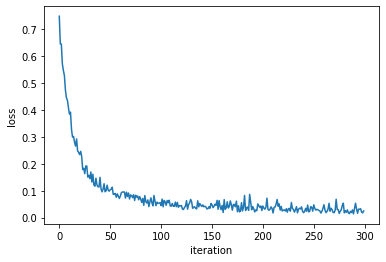

In [25]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


In [53]:


def show_data(data_sample):
    img=np.zeros((224,224,3))
    img[...,0]=data_sample[0].numpy()[0, 0, ...]
    img[...,1]=data_sample[0].numpy()[0, 1, ...]
    img[...,2]=data_sample[0].numpy()[0, 2, ...]
    
    plt.imshow(img/np.amax(img))
    plt.title('y = '+ str(data_sample[1]))

<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 


<b>Identify the first four misclassified samples using the validation data:</b>


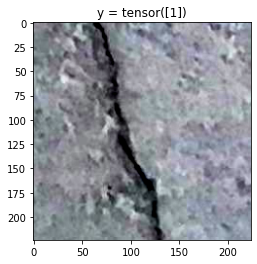

yhat:  tensor([0]) 



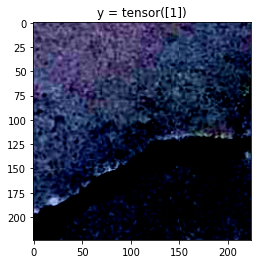

yhat:  tensor([0]) 



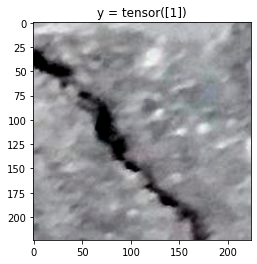

yhat:  tensor([0]) 



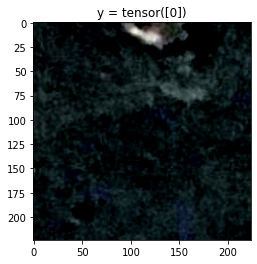

yhat:  tensor([1]) 



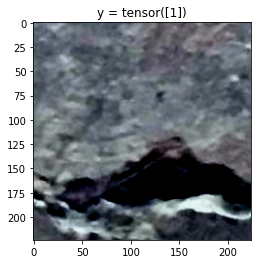

yhat:  tensor([0]) 



In [54]:
count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat, '\n')
        count += 1
    if count >= 5:
        break              

<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01"> CLICK HERE </a> Click here to see how to share your notebook.
